<h1>Projekt <b>Sztuczna inteligencja w muzyce</b> - zamiana obrazów w midi</h1>


**Import** danych z dysku google:

In [ ]:
import numpy as np

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False
# load numpy array from npy file

from numpy import load
# load array
imgs = load('/content/drive/My Drive/Ai/imgs7090x225.npy')
midis = load('/content/drive/My Drive/Ai/midis18x18.npy')

#midis.insert(midi)
# print the array
print(imgs.shape)
print(midis.shape)

Mounted at /content/drive
Note: using Google CoLab
(7090, 225)
(7090, 18, 18)


Użycie modelu aby wygenerować macierze MIDI 18x18



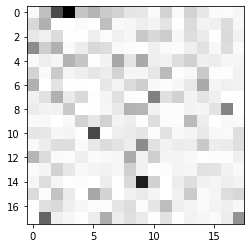

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('/content/drive/My Drive/Ai/generator_model_final_1K.h5')

#load img
vec = imgs[5]
vec = np.array(vec).reshape(1, 15*15)

#normalize it as <0;1>
vec = (vec.astype(np.float32)) / 255
# generate image
X = model.predict(vec)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


Jak widzimy powyżej model nie do końca tworzy to co od niego oczekujemy więc musimy wykonać kilka matemtycznych obliczeń aby uzyskać działający plik w standardach MIDI

In [ ]:
from keras.models import load_model
from numpy import asarray
import numpy as np

#predictAndPostprocess predictAndPostprocess predictAndPostprocess predictAndPostprocess
#imputs:
# modelName - os path to model in .h5 format
# imgVector225 - img converted to gray only channel egzamples in "imgs15x15.npz" and turned into vector
# cut - ilość obciętych wartości liczonych jako szum, domyślnie 60, w przyszłości można to zwiększyć lub inaczej klasyfikować w postprocessingu
#output:
# Returns ndarray in format (1,18,18,1)



def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = np.ceil(gray)
    return gray


def grayImgToVector(grayImg):
  temp = []
  for j in grayImg:
    for z in j:
      temp.append(z)
  return temp


def predictAndPostprocess(modelName, imgVector225, cut=100):
  model = load_model(modelName) # make it global for fast use
  vec = imgVector225
  vec = np.array(vec).reshape(1, 15*15)
  vec = (vec.astype(np.float32)) / 255

  X = model.predict(vec)

  Y = X
  max = np.max(Y)
  min = np.min(Y)
  Y = np.array([(x - min) / (max - min) for x in Y])*2-1

  Y = Y*544 +544 - 128 #((X_train.astype(np.float32) + 128) - 544 ) / 544
  Y = Y.astype(np.int16)
  #removes values between "cut" and -"cut"
  Y[(Y<cut) & (Y>-1*cut)] =0

  #zerowanie kolumn z ujemnym czasem
  for i in range(1,18):
    if Y[0][0][i][0] <= 0:
      Y[0][0][i][0] = 0
      for j in range(1,18):
        Y[0][j][i][0]=0

  Y=Y.transpose()

  #sortowanie kolunm po czasie
  temp=[]
  temp.append([Y[0][0]])
  b = []
  for i in range(1,18):
    if Y[0,i,0,0]!=0:
      b.append([i,Y[0,i,0,0]])
  b = np.array(b)
  b=b[b[:,1].argsort()]
  for el in b:
    temp[0].append(Y[0][el[0]])
  for i in range(len(temp[0]), 18):
    temp[0].append([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
  temp=np.array(temp)

  # temp
  temp = temp.astype('float64') 
  for i in range(0,18):
    for j in range(1,18):
      if temp[0][i][j][0] != 0.0:
        temp[0][i][j][0]=(temp[0][i][j][0]+128-554)/554
        if i!=0:
          temp[0][i][j][0]=(((temp[0][i][j][0]+1)/2)*254)-127
  temp[0][0] = np.abs(temp[0][0])*87+21
  temp[0][0][0][0] =0.0
  temp = temp.astype(np.int16)

  temp = temp.transpose()

  #return ndarray (1,18,18,1)
  return temp



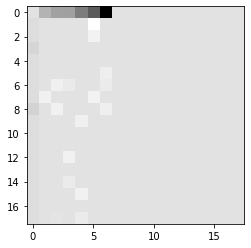

In [ ]:


wynik = predictAndPostprocess('/content/drive/My Drive/Ai/generator_model_final_50K.h5', imgs[5], 120)

pyplot.imshow(wynik[0,:, :, 0], cmap='gray_r')
pyplot.show()

Oryginalny plik:

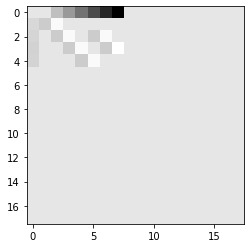

In [ ]:
pyplot.imshow(midis[5], cmap='gray_r')
pyplot.show()
